In [1]:
# ==========================================================
# FINAL OUT-OF-SAMPLE TEST SCRIPT FOR 2D ZONAL-MEAN MODELS
# ==========================================================
# This script contains all necessary code and corrected paths.
# Please use this to replace your entire out-of-sample notebook.

import os
import gc
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from keras.models import load_model
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# --- 1. Configuration: Set ONE Correct Path for Model Results ---
print("--- Setting up for Zonal-Mean Out-of-Sample Test ---")

# For CESM1:
#path_model_dir = '/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D'
# For CESM2:
path_model_dir = '/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_2D'

# Define variable names for your test files
In_name = "TS"
Out_name = "TOA_anom"

# Define paths to your TWO separate 4xCO2 test files
# # For CESM1:
# file_4xCO2_input = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.ANN.new.nc"
# file_4xCO2_output = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.zmean.ANN.new.nc"

# For CESM2:
file_4xCO2_input = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
file_4xCO2_output = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.zmean.ANN.nc"

# --- 2. Load Normalization Data from the Training Run ---
print("Loading normalization data...")
normalization_path = os.path.join(path_model_dir, 'Normalization_zonal.mat')
normalization = sio.loadmat(normalization_path)
X_mean = normalization['X_mean']
X_std = normalization['X_std']
y_mean = normalization['y_mean']
y_std = normalization['y_std']
print("✅ Normalization data loaded successfully.")

# --- 3. Load and Preprocess 4xCO2 Test Data ---
print("\nLoading and preprocessing 4xCO2 test data...")
ds_4xCO2_X = xr.open_dataset(file_4xCO2_input)
ds_4xCO2_y = xr.open_dataset(file_4xCO2_output)

# Extract variables from the correct files
TS_4xCO2_raw = ds_4xCO2_X[In_name]
TOA_4xCO2_truth = ds_4xCO2_y[Out_name].values
lat = ds_4xCO2_X['lat'].values
time_4xCO2 = ds_4xCO2_X['year'].values if 'year' in ds_4xCO2_X else ds_4xCO2_X['time'].values

# Normalize inputs correctly by adding the channel dimension first
TS_4xCO2_norm = (TS_4xCO2_raw.values[..., np.newaxis] - X_mean) / X_std
print("✅ Test data preprocessed.")

# --- 4. Prediction Loop ---
print("\n--- Running Ensemble Predictions for 4xCO2 ---")
n_folds = 5
predictions_from_folds = []

for fold_no in range(1, n_folds + 1):
    K.clear_session(); gc.collect()
    
    # Use the corrected, direct path to load the model
    model_path = os.path.join(path_model_dir, f'model_fold{fold_no}_ens1.h5')
    print(f"    Loading and predicting with model: {model_path}")
    
    model = load_model(model_path)
    
    pred_4xco2_norm = model.predict(TS_4xCO2_norm)
    pred_4xco2_unnorm = pred_4xco2_norm * y_std + y_mean
    predictions_from_folds.append(pred_4xco2_unnorm)

# Average predictions across the folds
Model_pred_4xco2 = np.mean(np.stack(predictions_from_folds), axis=0)
print("\n✅ Prediction complete.")

2025-07-24 04:26:51.481141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-24 04:26:51.595201: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 04:26:51.629543: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Setting up for Zonal-Mean Out-of-Sample Test ---
Loading normalization data...
✅ Normalization data loaded successfully.

Loading and preprocessing 4xCO2 test data...
✅ Test data preprocessed.

--- Running Ensemble Predictions for 4xCO2 ---
    Loading and predicting with model: /ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_2D/model_fold1_ens1.h5


2025-07-24 04:26:56.179446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-24 04:26:56.633177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2025-07-24 04:26:57.738649: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


5/5 [==============================] - 1s 11ms/step
    Loading and predicting with model: /ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_2D/model_fold2_ens1.h5
5/5 [==============================] - 0s 9ms/step
    Loading and predicting with model: /ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_2D/model_fold3_ens1.h5
5/5 [==============================] - 0s 9ms/step
    Loading and predicting with model: /ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_2D/model_fold4_ens1.h5
5/5 [==============================] - 0s 9ms/step
    Loading and predicting with model: /ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_2D/model_fold5_ens1.h5
5/5 [==============================] - 0s 9ms/step

✅ Prediction complete.



--- Starting Out-of-Sample Analysis ---

    Calculating Overall Pattern Correlation...
✅ Overall Pattern Correlation (r) = 0.5932

    Calculating and plotting R-squared per latitude...


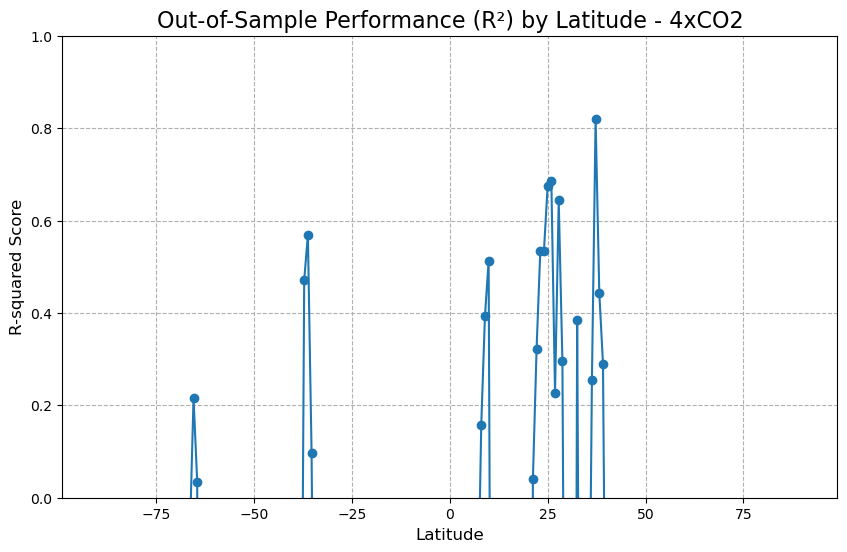


    Plotting Truth vs. Prediction as contour maps...


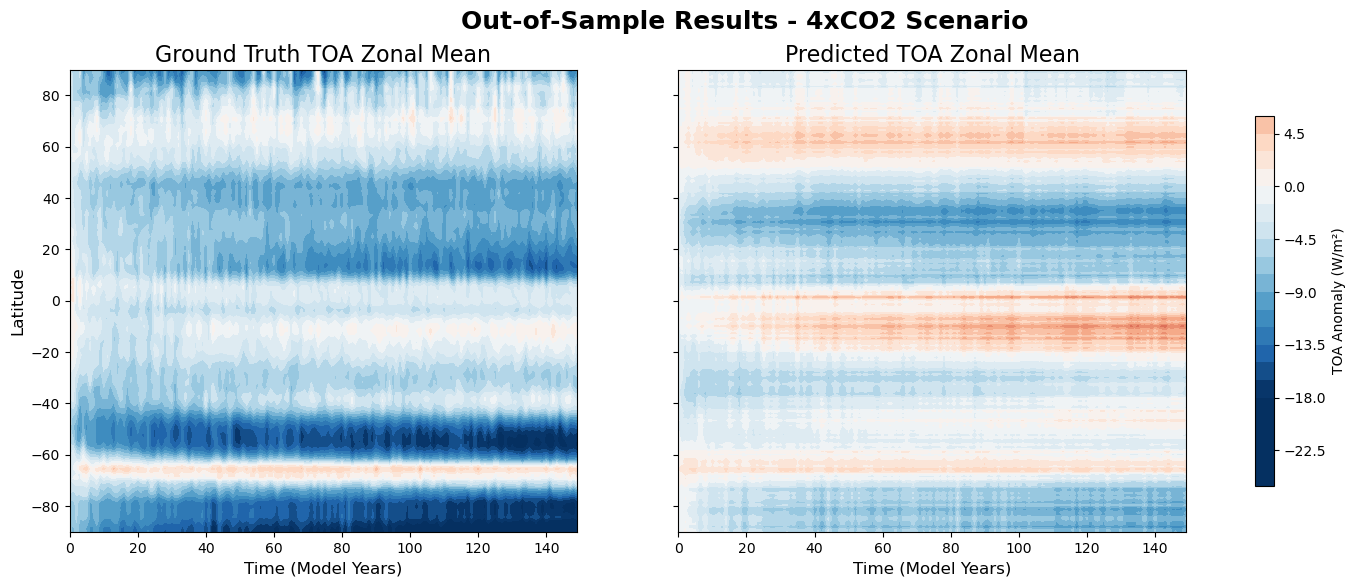

In [2]:
# ==========================================================
# Out-of-Sample Analysis and Visualization (Corrected Plotting Axis)
# ==========================================================
print("\n--- Starting Out-of-Sample Analysis ---")

# --- Task 1: Calculate Overall Pattern Correlation ---
print("\n    Calculating Overall Pattern Correlation...")
truth_flat = TOA_4xCO2_truth.flatten()
pred_flat = Model_pred_4xco2.flatten()
pattern_r, _ = pearsonr(truth_flat, pred_flat)
print(f"✅ Overall Pattern Correlation (r) = {pattern_r:.4f}")

# --- Task 2: Plot R-squared as a Function of Latitude ---
print("\n    Calculating and plotting R-squared per latitude...")
r2_by_latitude = [r2_score(TOA_4xCO2_truth[:, i], Model_pred_4xco2[:, i]) for i in range(len(lat))]

plt.figure(figsize=(10, 6))
plt.plot(lat, r2_by_latitude, marker='o', linestyle='-')
plt.title('Out-of-Sample Performance (R²) by Latitude - 4xCO2', fontsize=16)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('R-squared Score', fontsize=12)
plt.grid(True, linestyle='--'); plt.ylim(0, 1)
plt.show()

# --- Task 3: Plot Truth vs. Prediction as a 2D Contour Map ---
print("\n    Plotting Truth vs. Prediction as contour maps...")

# This creates a simple numerical axis [0, 1, 2, ...] for plotting
time_axis_for_plot = np.arange(TOA_4xCO2_truth.shape[0])

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
vmax = np.percentile(np.abs(TOA_4xCO2_truth), 98)
vmin = -vmax

axes[0].set_title('Ground Truth TOA Zonal Mean', fontsize=16)
# Use the new simple time axis for plotting
cf1 = axes[0].contourf(time_axis_for_plot, lat, TOA_4xCO2_truth.T, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0].set_xlabel('Time (Model Years)', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)

axes[1].set_title('Predicted TOA Zonal Mean', fontsize=16)
# Use the new simple time axis for plotting here as well
cf2 = axes[1].contourf(time_axis_for_plot, lat, Model_pred_4xco2.T, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1].set_xlabel('Time (Model Years)', fontsize=12)

fig.colorbar(cf1, ax=axes.ravel().tolist(), shrink=0.8, label='TOA Anomaly (W/m²)')
fig.suptitle("Out-of-Sample Results - 4xCO2 Scenario", fontsize=18, fontweight='bold')
plt.show()


--- Calculating and Comparing Weighted Global Means ---
✅ Weighted global means calculated.
    Overall Mean of Ground Truth: -6.1460 W/m²
    Overall Mean of Prediction:   -2.2879 W/m²

    Plotting global mean time series comparison...


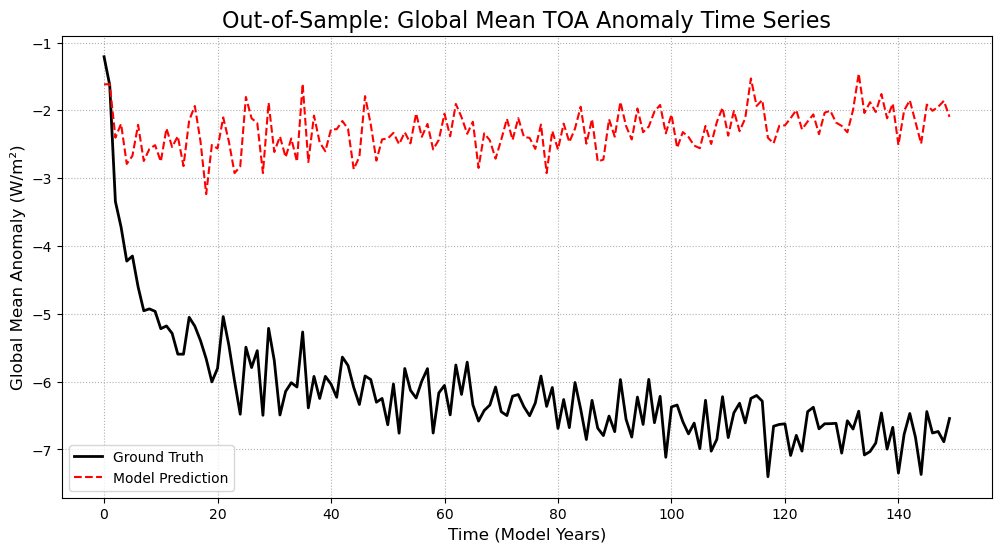

In [3]:
# =========================================================
# Task 4: Calculate and Compare Global Mean Time Series
# =========================================================
print("\n--- Calculating and Comparing Weighted Global Means ---")

# --- Step 1: Calculate Latitude Weights ---
# To get a true global mean, we must weight each latitude by the cosine
# of its angle to account for the smaller grid cell areas near the poles.
lat_radians = np.deg2rad(lat)
weights = np.cos(lat_radians)
# Ensure weights have the correct shape for broadcasting during the average
weights = weights[np.newaxis, :]

# --- Step 2: Calculate Weighted Average for Truth and Prediction ---
# We average over the latitude axis (axis=1) to get a single global
# mean value for each time step.
global_mean_truth = np.average(TOA_4xCO2_truth, axis=1, weights=weights.flatten())
global_mean_pred = np.average(Model_pred_4xco2, axis=1, weights=weights.flatten())

print("✅ Weighted global means calculated.")

# --- Step 3: Print and Compare the Overall Mean Values ---
# This gives a single number summary of the entire time series
print(f"    Overall Mean of Ground Truth: {np.mean(global_mean_truth):.4f} W/m²")
print(f"    Overall Mean of Prediction:   {np.mean(global_mean_pred):.4f} W/m²")

# --- Step 4: Plot the Global Mean Time Series for Comparison ---
print("\n    Plotting global mean time series comparison...")
plt.figure(figsize=(12, 6))
time_axis_for_plot = np.arange(global_mean_truth.shape[0])

plt.plot(time_axis_for_plot, global_mean_truth, label='Ground Truth', color='black', linewidth=2)
plt.plot(time_axis_for_plot, global_mean_pred, label='Model Prediction', color='red', linestyle='--')

plt.title('Out-of-Sample: Global Mean TOA Anomaly Time Series', fontsize=16)
plt.xlabel('Time (Model Years)', fontsize=12)
plt.ylabel('Global Mean Anomaly (W/m²)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')
plt.show()